<a href="https://colab.research.google.com/github/dirudiez/TFM_DiegoRudiez/blob/main/MultiLabel_CEL_inception_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificador Multilabel

https://walkwithfastai.com/Multi_Label

## Librerías

Instalamos la última versión de Fastai:

In [1]:
!pip install fastai -Uq
!pip install timm

#Reiniciamos el entorno de ejecución automáticamente
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

     |████████████████████████████████| 213 kB 5.0 MB/s 
     |████████████████████████████████| 61 kB 5.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 431 kB 5.0 MB/s 


{'restart': True, 'status': 'ok'}

In [1]:
!pip install wwf -q

Importamos las librerías necesarias:

In [2]:
from fastai.vision.all import *

#Estas liberías son para las arquitectuas EffiecientNet e Inception
import timm
from wwf.utils import *
from wwf.vision.timm import *

In [3]:
import pandas as pd

import torch
from torch import nn

from fastcore.meta import use_kwargs_dict

from fastai.callback.fp16 import to_fp16
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_one_cycle

from fastai.data.block import MultiCategoryBlock, DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import RandomSplitter, ColReader

from fastai.metrics import accuracy_multi, BaseLoss

from fastai.vision.augment import aug_transforms
from fastai.vision.data import ImageBlock
from fastai.vision.learner import cnn_learner

from torchvision.models import resnet34

## Dataset

Descargamos el dataset

In [4]:
!wget https://www.dropbox.com/s/o1eaoae59qgdo4i/Training_Set_Pre.zip?dl=0 --no-verbose -O train.zip
!wget https://www.dropbox.com/s/5od5cac9xhxlcwu/Test_Set_Pre.zip?dl=0 --no-verbose -O test.zip
!wget https://www.dropbox.com/s/gjz445xm4oddfus/Evaluation_Set_Pre.zip?dl=0 --no-verbose -O val.zip

2022-06-20 18:03:19 URL:https://ucb1722ecb180fe9f8a57caae4a8.dl.dropboxusercontent.com/cd/0/inline2/BnkX8KpZrwHgrNPRMa7ldKYB_Q-z_DN8H6ONIFiO5HhDNvfNO8ZuNkpxdCDj9_ZaH4MzmWZqwRPPDQhRXQIayxRy_DWQar-iGdvkuymUWqhTiwn2dMQn6Hc8eGjUogyI9ODdOeURpApE3AmNFPGTjY57ciJ2s7nqXHKzAPcYdaBZcAbRJ3pqmC2LZhQzCms2DPbky7AwrFFGi6_z96YKjUA3jywi7FNSmz0pAI6Mq2-KFomh8vLDfcD4dBdtGCXKmgeM166GMeEYWU41UtNjRJWnvAU7J05LsmdiMsYV9mbpt6deoWFjrH4C5ZMMaXvYVe5_mOrZAX4cNQo30CIEwDBCH1p1uQv9XVPa_VSfwmtD4p9CWJjPd16Bve1OdZS4Aaay6EZ7lnEGBD2PsQ8gtzMHNqqXea7b4Oasbyax5-8JgQ/file [138777773/138777773] -> "train.zip" [1]
2022-06-20 18:03:36 URL:https://uc2e097d929572bba7b7c6e5733d.dl.dropboxusercontent.com/cd/0/inline2/BnkYAI8xiMmoCdLdsGg9GNNx2gHesawA_oKwpYlwGVIK37f6a7A8vw7-CV6rOgCx-kFeovJPgTpQloLudWPntMB3hr1Lc9a10TRrdgo6gwLxVrQzrXWB0OjLA44mQoB0sJfPAXPlimqcOxcI8ZNH63cXvHeDrD1QGeCd3NyuzZHA7m50W3nsmfM8RVuPm6YBnXLgiBAJQoIUCRSyjfNXW36KS7s1-BJ_4wypkr6tdv1b51D45CGhUvTzgxqa9wDcaY2YOppGOBjbPh-Y8GsXolbD1WTqH_Ms-BQ830NeCXsFpmQFCAZAcq7L4-1EdZ4OjJl

In [5]:
# !rm -rvf Training_Set_Pre
!unzip -qq train.zip #-qq no verbose
!unzip -qq test.zip
!unzip -qq val.zip

In [6]:
trainPath = Path('Training_Set_Pre/')
testPath  = Path('Test_Set_Pre/')
valPath  =  Path('Evaluation_Set_Pre/')

In [7]:
df_train = pd.read_csv(str(trainPath) + '/train.csv')
df_test = pd.read_csv(str(testPath) + '/test.csv')
df_val = pd.read_csv(str(valPath) + '/val.csv')

In [8]:
df_train

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,...,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,RP,OTHER
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,1916,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1916,1917,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1917,1918,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1918,1919,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
def crearDataFrame(df, nombreConjunto):
  columnas = list(df.columns)[2:]

  nombres = [] #nombre de las imagenes
  enfermedades = [] #nombres de las enfermedades

  for i in df.index:
    cadena = ''
    nombres.append(nombreConjunto + str(df['ID'][i]))
    if df['Disease_Risk'][i] == 1:
      for x in columnas:
        if(df[x][i]==1):
          cadena += ' ' + x
    else:
      cadena = ' NORMAL'
    enfermedades.append(cadena[1:])
  data = {'nombre_img': nombres,
        'tags': enfermedades
        }
  return pd.DataFrame(data)

In [10]:
df_train_ML = crearDataFrame(df_train, str(trainPath) + '/Training/')
df_test_ML = crearDataFrame(df_test, str(testPath) + '/Test/')
df_val_ML = crearDataFrame(df_val, str(valPath) + '/Validation/')

In [11]:
df_train_ML.head(10)

,nombre_img,tags
0,Training_Set_Pre/Training/1,DR
1,Training_Set_Pre/Training/2,DR
2,Training_Set_Pre/Training/3,DR
3,Training_Set_Pre/Training/4,MH ODC
4,Training_Set_Pre/Training/5,DR LS
5,Training_Set_Pre/Training/6,ARMD MYA
6,Training_Set_Pre/Training/7,ARMD MYA
7,Training_Set_Pre/Training/8,ARMD MYA
8,Training_Set_Pre/Training/9,ERM
9,Training_Set_Pre/Training/10,NORMAL


In [12]:
df_train_ML['is_valid'] = False
df_val_ML['is_valid'] = True

In [13]:
df_train_val = pd.concat([df_train_ML, df_val_ML])

In [14]:
df_train_val

,nombre_img,tags,is_valid
0,Training_Set_Pre/Training/1,DR,False
1,Training_Set_Pre/Training/2,DR,False
2,Training_Set_Pre/Training/3,DR,False
3,Training_Set_Pre/Training/4,MH ODC,False
4,Training_Set_Pre/Training/5,DR LS,False
...,...,...,...
635,Evaluation_Set_Pre/Validation/636,TSLN,True
636,Evaluation_Set_Pre/Validation/637,TSLN,True
637,Evaluation_Set_Pre/Validation/638,NORMAL,True
638,Evaluation_Set_Pre/Validation/639,NORMAL,True


In [15]:
# df_train_val[df_train_val['nombre_img']=='val/640']['is_valid'].values[0]

In [16]:
def conjuntoImg(nombreImg):
  return True if df[df['nombre_img'] == nombreImg[0]]['is_valid'].values[0] else False

In [17]:
df = df_train_val

In [18]:
conjuntoImg(['Training_Set_Pre/Training/503','ODP', True])

False

## Datablock

In [19]:
# batch_tfms = aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [20]:
db = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                  get_x=ColReader(0, suff='.png'),
                  splitter=FuncSplitter(conjuntoImg),
                  get_y=ColReader(1, label_delim=' '),
                  item_tfms = Resize(256),
                  batch_tfms = aug_transforms(size=128,min_scale=0.75))

In [21]:
dls = db.dataloaders(df.values)

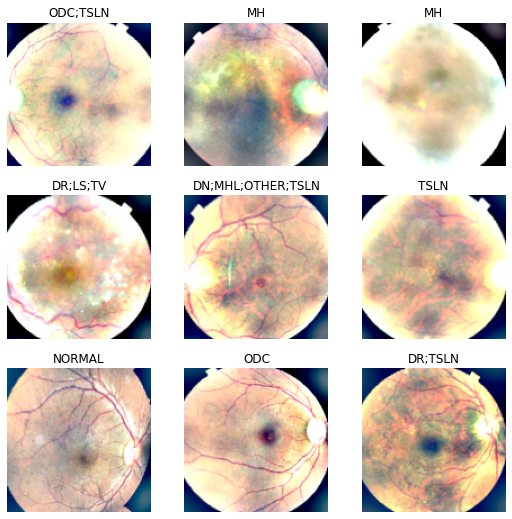

In [22]:
dls.show_batch()

## Entrenar Modelo

In [23]:
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=20),
    SaveModelCallback()
]

In [24]:
metrics = [ accuracy_multi, PrecisionMulti(), RecallMulti(), F1ScoreMulti() ]
learn = timm_learner(dls, "inception_v3", pretrained=True, metrics=metrics, cbs=callbacks).to_fp16()

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


SuggestedLRs(minimum=0.03019951581954956, steep=0.03981071710586548)

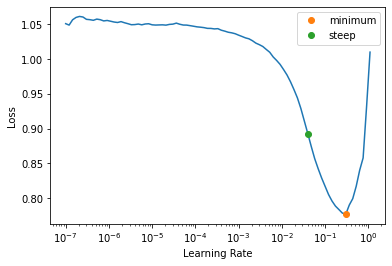

In [25]:
learn.lr_find(suggest_funcs=(minimum, steep))

epoch,train_loss,valid_loss,accuracy_multi,precision_score,recall_score,f1_score,time
0,0.628025,0.214527,0.955280,0.085710,0.006453,0.011794,00:12


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with valid_loss value: 0.21452681720256805.


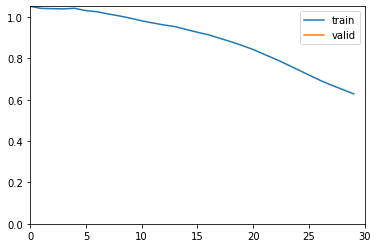

epoch,train_loss,valid_loss,accuracy_multi,precision_score,recall_score,f1_score,time
0,0.173521,0.145352,0.957974,0.110655,0.036592,0.049007,00:11
1,0.163412,0.149119,0.958136,0.114258,0.027455,0.040167,00:11
2,0.153866,0.139776,0.959160,0.123969,0.036171,0.050329,00:11
3,0.146712,0.132318,0.959914,0.111882,0.046166,0.057077,00:11
4,0.140427,0.137509,0.959537,0.152138,0.064960,0.076593,00:11
5,0.135060,0.128000,0.961422,0.144414,0.061145,0.077804,00:11
6,0.129693,0.123831,0.961961,0.164797,0.083827,0.098993,00:11
7,0.124431,0.122894,0.961800,0.203586,0.084289,0.103368,00:11
8,0.120969,0.130647,0.962608,0.166729,0.099905,0.118586,00:11
9,0.116137,0.135872,0.962284,0.240986,0.103386,0.126379,00:11


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with valid_loss value: 0.14535245299339294.


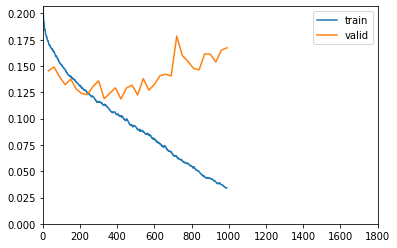

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 2 with valid_loss value: 0.13977575302124023.


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 3 with valid_loss value: 0.13231757283210754.


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 5 with valid_loss value: 0.12799996137619019.


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 6 with valid_loss value: 0.12383147329092026.


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 7 with valid_loss value: 0.12289373576641083.


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 10 with valid_loss value: 0.11891166865825653.


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 13 with valid_loss value: 0.11873944848775864.


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr

No improvement since epoch 13: early stopping


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
learn.fine_tune(60,base_lr=2e-2)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


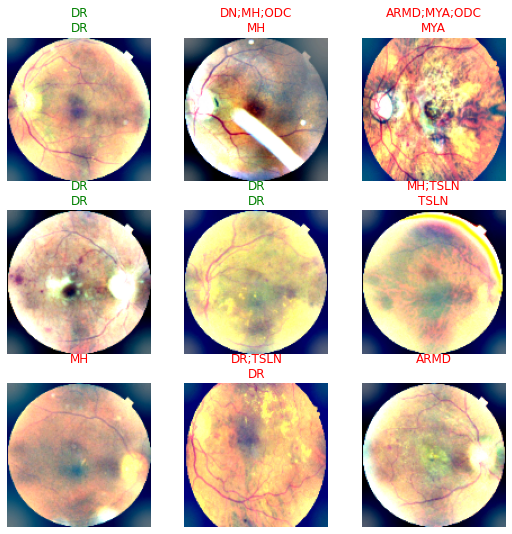

In [27]:
learn.show_results()

## Evaluar el modelo

In [28]:
dbTest = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=ColReader(0, suff='.png'),
                   splitter=RandomSplitter(),
                   get_y=ColReader(1, label_delim=' '),
                   item_tfms = Resize(256),
                   batch_tfms = aug_transforms(size=128,min_scale=0.75))

In [29]:
dlsTest = dbTest.dataloaders(df_test_ML)

In [30]:
learn.dls = dlsTest

In [31]:
learn.validate()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Better model found at epoch 0 with valid_loss value: 0.962553858757019.


(#5) [0.1349898725748062,0.962553858757019,0.2644157088122605,0.15434750878528988,0.1838388793016742]

Exportamos el modelo

In [32]:
learn.to_fp32()
learn.export('MultiLabel_CEL_inception_v3.pkl')

## Comprobaciones manuales

In [33]:
learn_inf = load_learner('MultiLabel_CEL_inception_v3.pkl')

In [34]:
df_test[df_test['Disease_Risk']==1] #enfermedad

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,...,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,RP,OTHER
0,1,1,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,5,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,636,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
636,637,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
637,638,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
638,639,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [35]:
df_test[df_test['Disease_Risk']==0] #sanas
# df_test.iloc[0:20,:]

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,...,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,RP,OTHER
244,245,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
271,272,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
272,273,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
275,276,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
276,277,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
622,623,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
625,626,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
626,627,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
627,628,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Imágenes con enfermedad**

In [36]:
learn_inf.predict('Test_Set_Pre/Test/1.png')[0] #DR, TLSN

(#0) []

In [37]:
learn_inf.predict('Test_Set_Pre/Test/2.png')[0] #DR, BRVO

(#1) ['DR']

In [38]:
learn_inf.predict('Test_Set_Pre/Test/3.png')[0] #DR, ODC

(#0) []

In [39]:
learn_inf.predict('Test_Set_Pre/Test/10.png')[0] #DR, LS, ODC

(#0) []

**Imágenes normales:**

In [40]:
learn_inf.predict('Test_Set_Pre/Test/272.png')[0]

(#1) ['NORMAL']

In [41]:
learn_inf.predict('Test_Set_Pre/Test/623.png')[0]

(#0) []

In [42]:
learn_inf.predict('Test_Set_Pre/Test/626.png')[0]

(#1) ['NORMAL']

In [43]:
learn_inf.predict('Test_Set_Pre/Test/628.png')[0]

(#1) ['NORMAL']

In [44]:
learn_inf.predict('Test_Set_Pre/Test/629.png')[0]

(#1) ['NORMAL']